In [1]:
# Libraries
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.regularizers import l1 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import librosa
from sklearn.utils import shuffle
from keras.utils import to_categorical
import librosa
import matplotlib.pyplot as plt
from keras.models import load_model
import keras
from tensorflow.keras.layers import LeakyReLU

In [2]:
# Examining data keys
hf = h5py.File('spectrogramsv2.h5', 'r')
list(hf.keys())

['amecro',
 'barswa',
 'bkcchi',
 'blujay',
 'daejun',
 'houfin',
 'mallar3',
 'norfli',
 'rewbla',
 'stejay',
 'whcspa']

In [3]:
# Examining data
# Get the spectrogram data for 'rewbla'
spectrogram_data = hf['rewbla']

spectrogram_data[:1]


array([[[5.33071556e-04, 1.09047905e-04, 4.46705574e-05, ...,
         1.21544971e-03, 8.15755796e-02, 2.31675270e-02],
        [3.90198578e-04, 2.84078483e-04, 1.90737218e-03, ...,
         5.20743931e-04, 4.00938440e-03, 9.08755814e-02],
        [3.64501943e-05, 2.07158948e-04, 7.19847105e-04, ...,
         2.51694653e-03, 5.32579502e-02, 3.46706348e-02],
        ...,
        [1.01117740e-04, 8.38956978e-05, 9.91304579e-04, ...,
         5.55887525e-03, 9.99477711e-02, 8.64895303e-03],
        [1.41962520e-04, 2.98510016e-04, 7.12100080e-04, ...,
         4.56845565e-03, 1.70801159e-02, 1.50730132e-02],
        [3.19267256e-04, 4.88891137e-04, 5.71051199e-04, ...,
         3.20766014e-03, 1.56251531e-02, 9.91992938e-02]]])

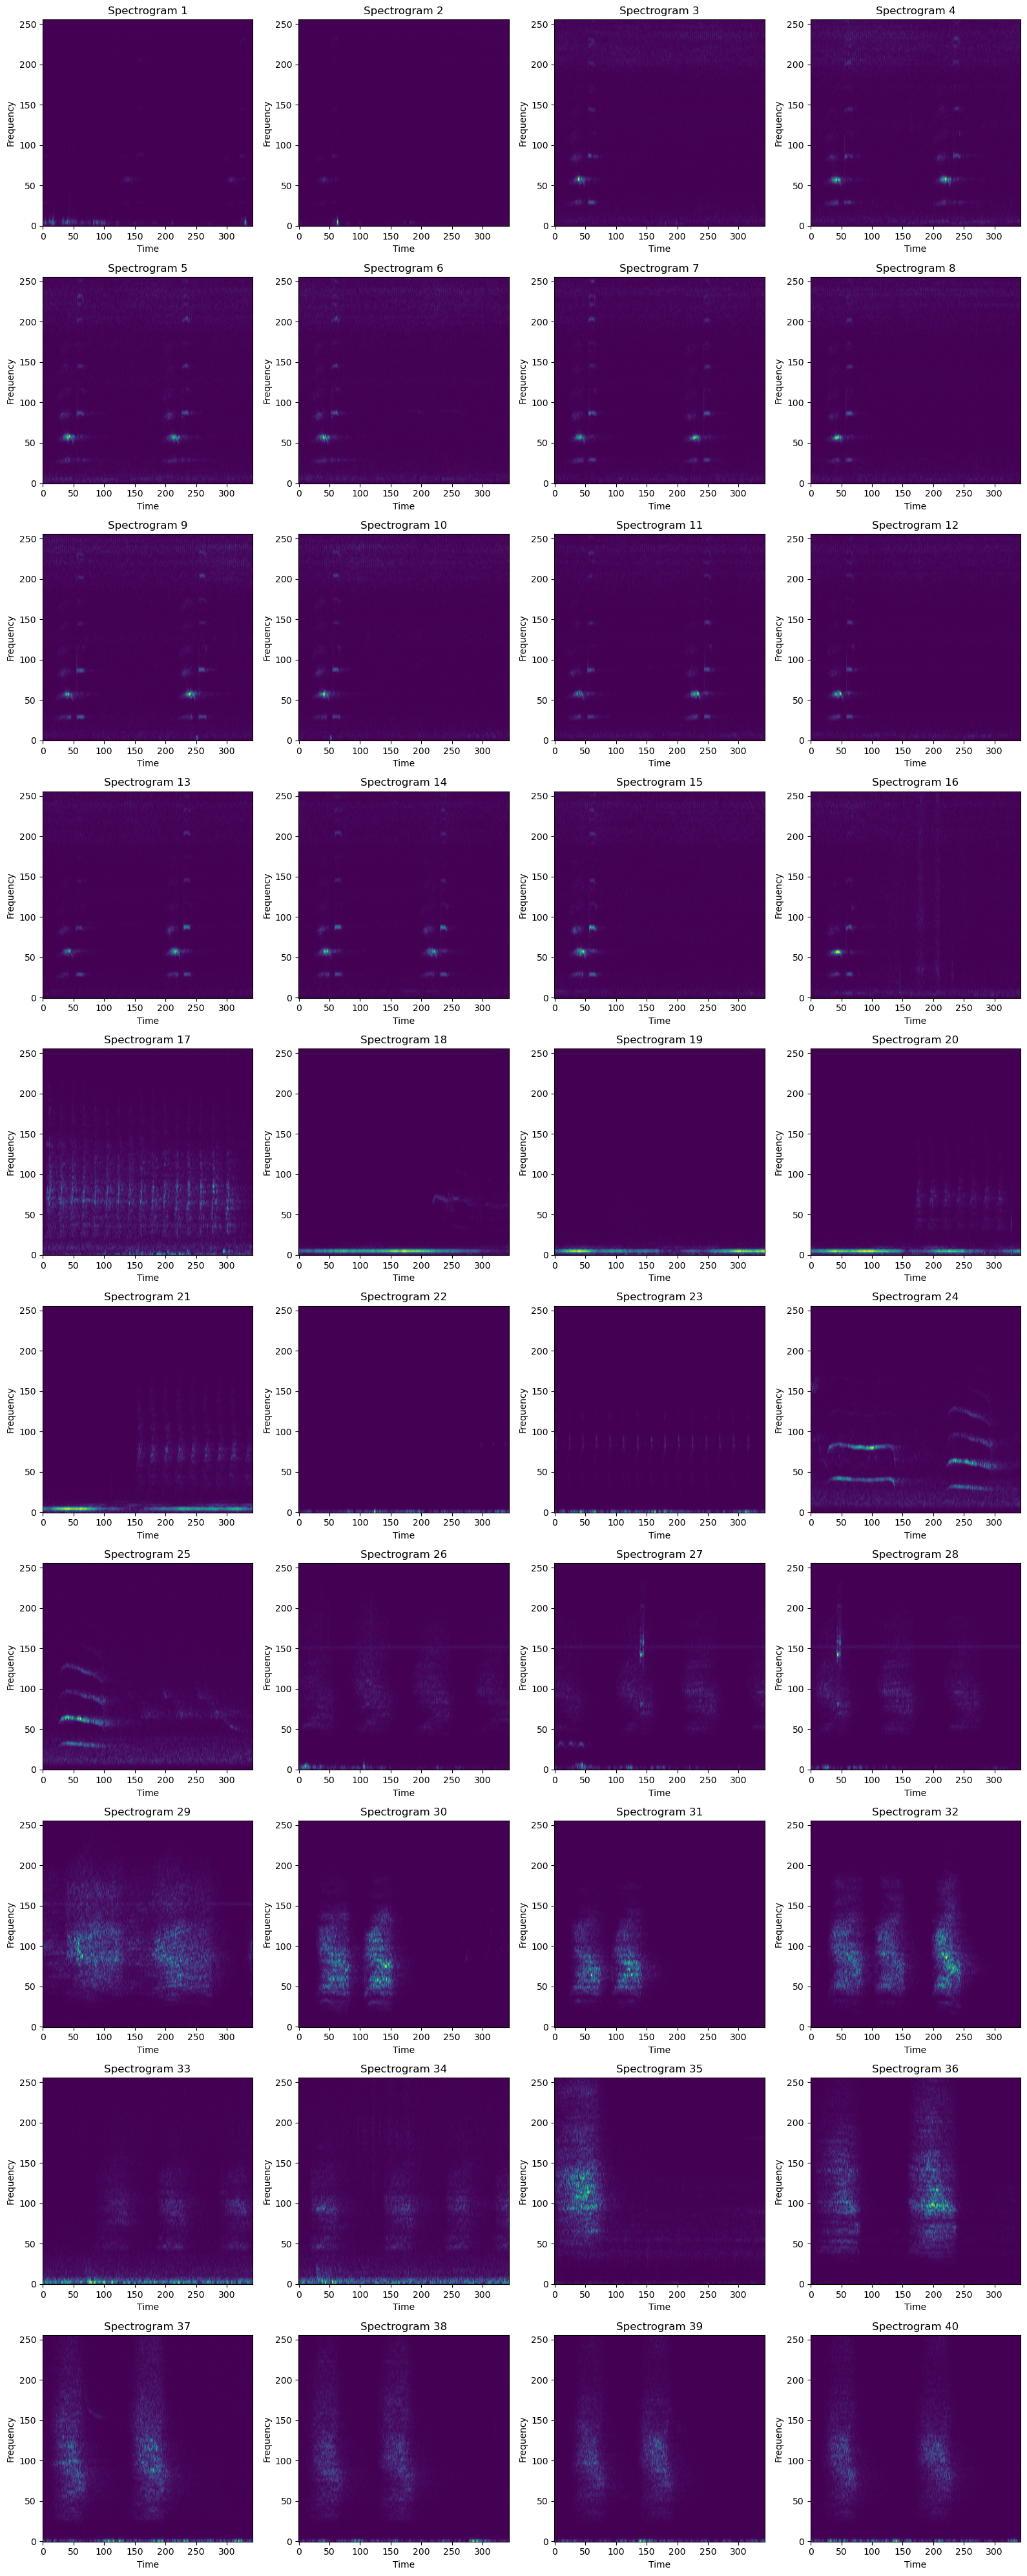

In [4]:
# Examining data
# Plotting all spectrograms for western meadowlark

# Load the HDF5 file
hf = h5py.File('spectrogramsv2.h5', 'r')

# Get the spectrogram data for 'stejay'
spectrogram_data = hf['stejay']

# Get the number of spectrograms in the dataset
num_spectrograms = spectrogram_data.shape[2]

# Calculate the number of rows and columns for subplots
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_spectrograms + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))

# Plot each spectrogram
for i in range(num_spectrograms):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    spectrogram = spectrogram_data[:, :, i]
    ax.imshow(spectrogram, cmap='viridis', origin='lower', aspect='auto')  # Stretch spectrogram vertically
    ax.set_title(f'Spectrogram {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

# Hide empty subplots if there are any
for i in range(num_spectrograms, num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].axis('off')

plt.tight_layout()
plt.show()

# Close the HDF5 file
hf.close()

Data prep

In [6]:
# Reading in data from .h5 file
with h5py.File('spectrogramsv2.h5', 'r') as f:
    # Retrieving keys and data for each spectrogram  
    all_spectrograms = [f[key][()] for key in f.keys()]
    # Each spectrogram is a 3D array, 3rd dimension is the length(or time frames)
    max_length = max(spectrogram.shape[2] for spectrogram in all_spectrograms)
    # Empty list to store spectrograms
    padded_spectrograms = []
    for spectrogram in all_spectrograms:
        # Pad the spectrogram along the batch size dimension to make sure all inputs are the same size
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, 0), (0, max_length - spectrogram.shape[2])), mode='constant')
        padded_spectrograms.append(padded_spectrogram)

# Convert to array, necessary format and data structure for CNNs
padded_spectrograms_array = np.array(padded_spectrograms)

# Concatenate the padded spectrograms along time dimension 
concatenated_spectrograms = np.concatenate(padded_spectrograms_array, axis=2)

# Transpose the spectrograms, necessary for CNN for image-like data
# (time_steps, frequency bins, channels)
spectrograms = np.transpose(concatenated_spectrograms, (2, 0, 1))

# Assign labels from 0 to 11
num_categories = len(all_spectrograms)
labels = np.concatenate([np.full((padded_spectrogram.shape[2],), i) for i in range(num_categories)])


In [7]:
# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2, random_state=50)

# one-hot encoded classes
y_train = to_categorical(y_train, num_classes=11)
y_test = to_categorical(y_test, num_classes=11)

In [8]:
# Check training shape
X_train.shape

(519, 256, 343)

In [9]:
model = Sequential([
    Flatten(input_shape=(256,343)),
    Dense(64),
    LeakyReLU(alpha=0.02),
    Dense(64),
    LeakyReLU(alpha=0.02),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(11, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=50, validation_split=0.2)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1292 - loss: 2.4064 - val_accuracy: 0.3173 - val_loss: 2.2140
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3605 - loss: 1.9700 - val_accuracy: 0.3462 - val_loss: 1.9576
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5473 - loss: 1.5640 - val_accuracy: 0.3462 - val_loss: 1.9017
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6133 - loss: 1.2747 - val_accuracy: 0.4135 - val_loss: 1.7232
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6946 - loss: 1.0242 - val_accuracy: 0.4519 - val_loss: 1.7784
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7697 - loss: 0.8359 - val_accuracy: 0.5192 - val_loss: 1.6093
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7702 - loss: 0.7410 - val_accuracy: 0.4712 - val_loss: 1.8023
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8166 - loss: 0.6044 - val_accuracy: 0.4712 - val_loss: 1.9112


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


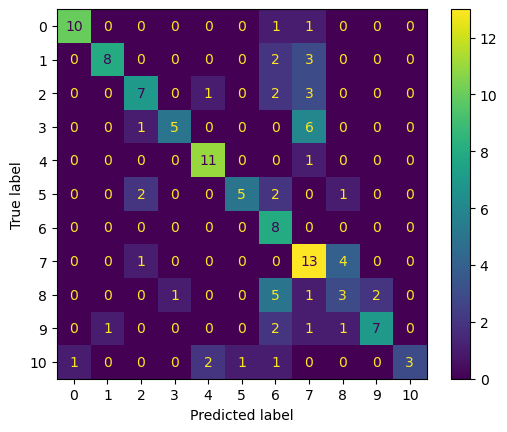

In [11]:
y_true = np.argmax(y_test, axis=1)
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes)
plt.show()

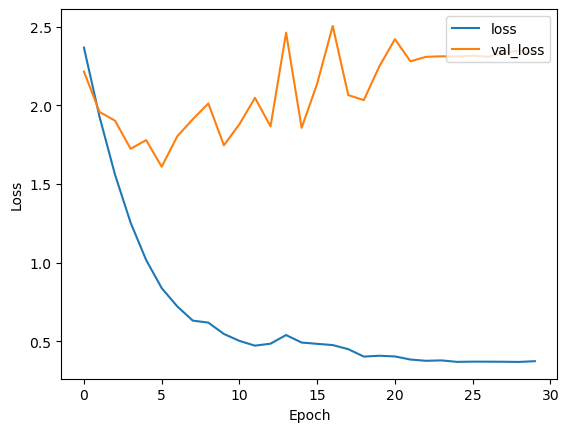

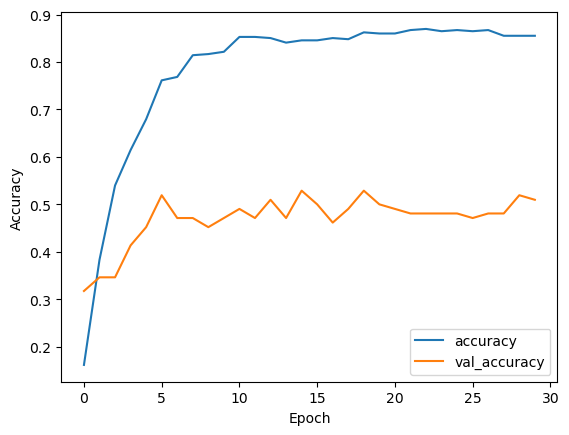

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show();
plt.savefig('multi4loss.jpg')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show();

In [ ]:
# Define the CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 343, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', kernel_regularizer = l2(0.1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    #Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_regularizer = l2(0.1)),
    #MaxPooling2D(pool_size=(2,2)),
    #Dropout(0.1),
    #Conv2D(filters=256, kernel_size=(3,3),activation='relu', kernel_regularizer = l2(0.1)),
    #MaxPooling2D(pool_size=(2,2)),
    #Dropout(0.1),
    #Conv2D(filters=256, kernel_size=(3,3),activation='relu', kernel_regularizer = l2(0.1)),
    #MaxPooling2D(pool_size=(2,2)),
    #Dropout(0.1),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(11, activation='softmax')  
])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])